In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision.models.vgg import VGG
from sklearn.metrics import confusion_matrix
import pandas as pd
import scipy.misc
import random
import sys

if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2

from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import numpy as np
import time
import os

## Define FCN16s model for deconvolution layers

In [2]:
class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super(FCN16s, self).__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace = True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

## Define VGG16 for convolution layers

In [3]:
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super(VGGNet, self).__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):      
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x
        return output

In [4]:
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

## Define training parameter

In [5]:
batch_size = 6
epochs     = 100 #500
lr         = 1e-4
momentum   = 0
w_decay    = 1e-5
step_size  = 50
gamma      = 0.5
model_use  = "barcode" # "products_20" "mini_competition"
n_class = 8
means     = np.array([103.939, 116.779, 123.68]) / 255. 

## Define path, directory trainning environment

In [6]:
# get data
data_dir  = os.path.join("data", model_use)
if not os.path.exists(data_dir):
    print("Data not found!")
# create dir for model
model_dir = os.path.join("models", model_use)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# create dir for score
score_dir = os.path.join("scores", model_use)
if not os.path.exists(score_dir):
    os.makedirs(score_dir)

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)
#use_gpu = False
if use_gpu:
    ts = time.time()
    vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))

Data not found!
Finish cuda loading, time elapsed 1.90228199959


## Define dataloader and optimizer

In [7]:
import argparse
def rotate_cv(image, center=None, scale=1.0):
    (h, w) = image.shape[:2]
    print(h,w)
    if center is None:
        
        center = (w / 2, h / 2)
    M_90 = cv2.getRotationMatrix2D(center, 90, scale)
    M_180 = cv2.getRotationMatrix2D(center, 180, scale)
    M_270 = cv2.getRotationMatrix2D(center, 270, scale)
    rotated_90 = cv2.warpAffine(image, M_90, (h, w))
    rotated_180 = cv2.warpAffine(image, M_180, (w, h))
    rotated_270 = cv2.warpAffine(image, M_270, (h, w))
    return rotated_90, rotated_180, rotated_270
def rotate_back(image, center=None, scale=1.0, angle=0):
    (h, w) = image.shape[:2]
    print(h,w)
    if center is None:
        center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated
def rotate_back_change_h_w(image, center=None, scale=1.0, angle=0):
    (h, w) = image.shape[:2]
    print(h,w)
    if center is None:
        center = (h / 2, w / 2)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (h, w))
    return rotated

### HW: Plot three graphs: Training loss, class IOU curve, class F-score curve  

In [8]:
def test(model_name, data_path):
    state_dict = torch.load(os.path.join(model_dir, model_name))
    fcn_model.load_state_dict(state_dict)
    img        = cv2.imread(data_path,cv2.IMREAD_UNCHANGED)
    origin     = img
    img        = img[:, :, ::-1]  # switch to BGR

    img = np.transpose(img, (2, 0, 1)) / 255.
    img[0] -= means[0]
    img[1] -= means[1]
    img[2] -= means[2]

    # convert to tensor
    img = img[np.newaxis,:]
    img = torch.from_numpy(img.copy()).float() 
    output = fcn_model(img)
    output = output.data.cpu().numpy()

    N, _, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

    # show images
    
    img = img.numpy()
    for i in range(N):
        plt.figure()
        origin = cv2.cvtColor(origin, cv2.COLOR_BGR2RGB)
        plt.title("origin_img")
        plt.imshow(origin)
        plt.figure()
        plt.title("prediction")
        plt.imshow(pred[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

    plt.show()

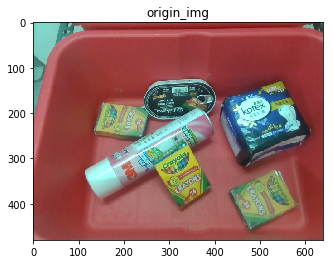

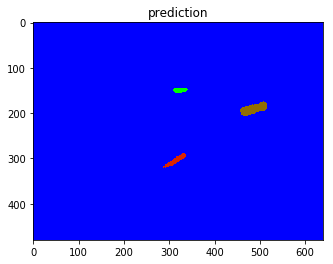

In [9]:
test("FCNs_barcode_batch6_epoch44_RMSprop_lr0.0001.pkl","1.jpg")

In [10]:
from PIL import Image as Image_PIL
def brand_prediction(model_name, data_path):
    state_dict = torch.load(os.path.join(model_dir, model_name))
    fcn_model.load_state_dict(state_dict)
    fcn_model.eval()
    img        = cv2.imread(data_path,cv2.IMREAD_UNCHANGED)
    origin = img
    gray_image_90, gray_image_180, gray_image_270 = rotate_cv(img)
    
    gray_image = img
    gray_image = gray_image[:, :, ::-1]  # switch to BGR
    gray_image = np.transpose(gray_image, (2, 0, 1)) / 255.
    gray_image[0] -= means[0]
    gray_image[1] -= means[1]
    gray_image[2] -= means[2]
    g1 = np.zeros((2,3,480,640), dtype = np.float32)
    g1[0] = gray_image
    
    gray_image = gray_image_180
    gray_image = gray_image[:, :, ::-1]  # switch to BGR
    gray_image = np.transpose(gray_image, (2, 0, 1)) / 255.
    gray_image[0] -= means[0]
    gray_image[1] -= means[1]
    gray_image[2] -= means[2]
    g1[1] = gray_image
    
    g1 = torch.from_numpy(g1).float() 
    output = fcn_model(g1)
    output = output.data.cpu().numpy()
    N, _, h, w = output.shape
    mask1 = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

    
    gray_image = gray_image_90
    gray_image = gray_image[:, :, ::-1]  # switch to BGR
    gray_image = np.transpose(gray_image, (2, 0, 1)) / 255.
    gray_image[0] -= means[0]
    gray_image[1] -= means[1]
    gray_image[2] -= means[2]
    g2 = np.zeros((2,3,640,480), dtype = np.float32)
    g2[0] = gray_image
    
    gray_image = gray_image_270
    gray_image = gray_image[:, :, ::-1]  # switch to BGR
    gray_image = np.transpose(gray_image, (2, 0, 1)) / 255.
    gray_image[0] -= means[0]
    gray_image[1] -= means[1]
    gray_image[2] -= means[2]
    g2[1] = gray_image
    
    g2 = torch.from_numpy(g2).float() 
    output = fcn_model(g2)
    output = output.data.cpu().numpy()
    N, _, h, w = output.shape
    mask2 = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w) 

    pred_original_mask = np.zeros((2,480,640))
    for batch_idx in range(0,2):
        image = Image_PIL.fromarray(mask1[batch_idx].astype(np.uint8), mode='P')
        pred_original_mask[batch_idx,:,:] = np.array(image)   # original prediction result from Softmax
    pred_original_mask_2 = np.zeros((2,640,480))
    for batch_idx in range(0,2):
        image = Image_PIL.fromarray(mask2[batch_idx].astype(np.uint8), mode='P')
        pred_original_mask_2[batch_idx,:,:] = np.array(image)   # original prediction result from Softmax
    

    mask_l = []
    mask_l.append(pred_original_mask[0,:,:])
    mask_l.append(rotate_back_change_h_w(pred_original_mask_2[0,:,:], angle = -90))
    mask_l.append(rotate_back(pred_original_mask[1,:,:], angle = -180))
    mask_l.append(rotate_back_change_h_w(pred_original_mask_2[1,:,:], angle = -270))
    mask_l = np.asarray(mask_l) 
    
    for i in range(4):
        plt.figure()
        origin1 = cv2.cvtColor(origin, cv2.COLOR_BGR2RGB)
        plt.title("origin_img")
        plt.imshow(origin1)
        plt.figure()
        plt.title("prediction")
        plt.imshow(mask_l[i],cmap = "brg",vmin = 0, vmax = n_class - 1)
    plt.show()    

    return mask_l.astype(np.uint8)

(480, 640)
(640, 480)
(480, 640)
(640, 480)


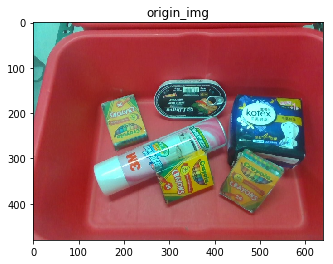

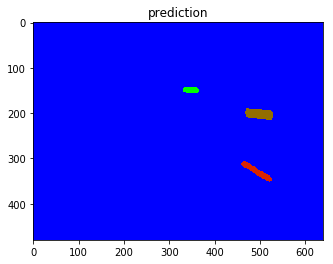

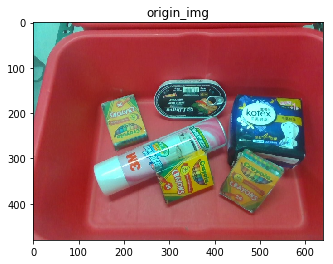

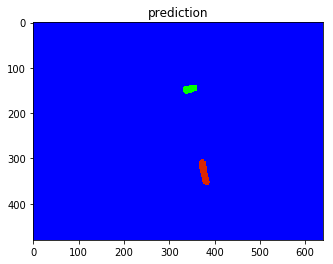

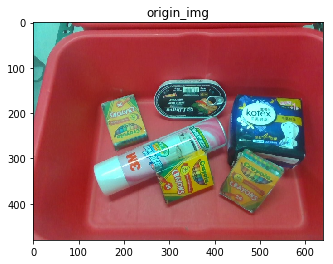

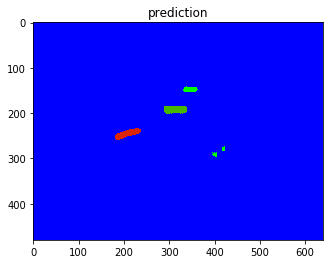

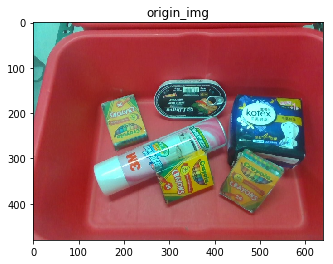

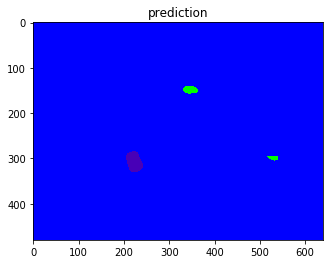

In [101]:
mask_l = brand_prediction("FCNs_barcode_batch6_epoch44_RMSprop_lr0.0001.pkl","1.jpg")


(493, 328)
(498, 202)
(348, 149)
[0 4]
(377, 330)
[0 4 6]
(208, 245)
(313, 192)
[0 1]
(223, 307)


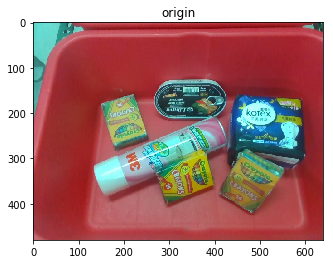

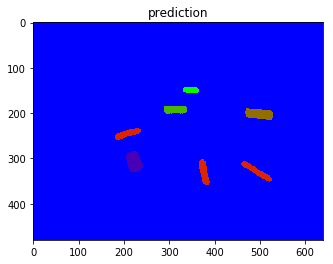

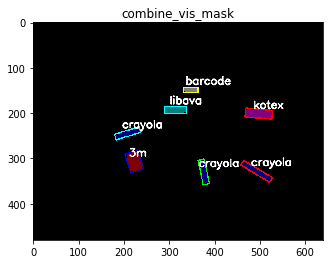

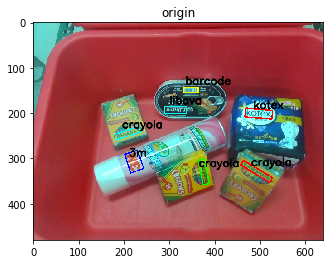

In [104]:
img = cv2.imread("1.jpg",cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
origin = img.copy()
mask = np.zeros((480,640), dtype = np.float32)
degree = 0
combine_vis_mask = np.zeros((480,640,3),dtype=np.uint8)
for i in range(4):
    m = mask_l[i]
    if i != 0:
        print(np.unique(m))
        m[m == 7] = 0
    vis_mask = find_all_direction(m, degree, 50)
    combine_vis_mask += vis_mask       
    mask += m
    degree += 90


plt.title("origin")
plt.imshow(img,cmap = "brg",vmin = 0, vmax = n_class - 1)
plt.show() 

plt.title("prediction")
plt.imshow(mask,cmap = "brg",vmin = 0, vmax = n_class - 1)
plt.show()  
plt.title("combine_vis_mask")
plt.imshow(combine_vis_mask,cmap = "brg",vmin = 0, vmax = n_class - 1)
combine_vis_mask = cv2.cvtColor(combine_vis_mask, cv2.COLOR_RGB2BGR)
cv2.imwrite('mask.jpg', combine_vis_mask)
plt.show()    
plt.title("origin")
plt.imshow(origin,cmap = "brg",vmin = 0, vmax = n_class - 1)
origin = cv2.cvtColor(origin, cv2.COLOR_RGB2BGR)
cv2.imwrite('img_cls.jpg', origin)
plt.show() 

In [89]:
brand_name =['Background','3m','andes','cocacola','crayola','kotex','libava','barcode']

def uint82bin(n, count=8):
    """returns the binary of integer n, count refers to amount of bits"""
    return ''.join([str((n >> y) & 1) for y in range(count-1, -1, -1)])
def labelcolormap(N):
    cmap = np.zeros((N, 3), dtype = np.uint8)
    for i in range(N):
        r = 0
        g = 0
        b = 0
        id = i
        for j in range(7):
            str_id = uint82bin(id)
            r = r ^ ( np.uint8(str_id[-1]) << (7-j))
            g = g ^ ( np.uint8(str_id[-2]) << (7-j))
            b = b ^ ( np.uint8(str_id[-3]) << (7-j))
            id = id >> 3
        cmap[i, 0] = r
        cmap[i, 1] = g

        cmap[i, 2] = b
    return cmap

c_map = labelcolormap(21)

def gen_vis_brand_mask(object_mask,brand_class, angle):
    ret,thresh = cv2.threshold(object_mask,127,255,0)
    cnts = cv2.findContours(thresh,cv2.RETR_TREE,   cv2.CHAIN_APPROX_TC89_L1)

    cnt = cnts[0]
    rect = cv2.minAreaRect(cnt[0])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    id = brand_class
    M = cv2.moments(cnt[0])

    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    print(cX,cY)
    color = np.zeros((480,640, 3), dtype = np.uint8)
    color[object_mask == 255] = c_map[id]
    if id == 7:
        cv2.drawContours(color,[box],0,(255,255,0),2)
        cv2.drawContours(origin,[box],0,(255,255,0),2)
    elif angle == 0:
        cv2.drawContours(color,[box],0,(255,0,0),2)
        cv2.drawContours(origin,[box],0,(255,0,0),2)
    elif angle == 90:
        cv2.drawContours(color,[box],0,(0,255,0),2)
        cv2.drawContours(origin,[box],0,(0,255,0),2)
    elif angle == 180:
        cv2.drawContours(color,[box],0,(0,255,255),2)
        cv2.drawContours(origin,[box],0,(0,255,255),2)
    else :
        cv2.drawContours(color,[box],0,(0,0,255),2)
        cv2.drawContours(origin,[box],0,(0,0,255),2)
    cv2.putText(color,brand_name[id],(cX-12, cY-12), cv2.FONT_HERSHEY_SIMPLEX, 0.8,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(origin,brand_name[id],(cX-12, cY-12), cv2.FONT_HERSHEY_SIMPLEX, 0.8,(0,0,0),2,cv2.LINE_AA)
    
    return color
def find_all_direction(mask_frame, pred_angle, thres):

    vis_mask = np.zeros((480,640,3),dtype=np.uint8)

    class_list = (np.unique(mask_frame))

    mask_list = []
    for i in class_list:
        if  i != 0:
            mask = np.zeros(np.shape(mask_frame),dtype=np.uint8)
            mask[mask_frame == i] = 255
            mask_list.append(mask)


    count = 1
    for mask in mask_list:

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3, 3))
        for i in range(0,5,1):
            improved_mask = cv2.dilate(mask, kernel)
        for i in range(0,5,1):
            improved_mask = cv2.erode(mask, kernel)
        binary_mask = cv2.threshold(improved_mask, 127, 255, cv2.THRESH_BINARY)[1]
        ret, labels = cv2.connectedComponents(binary_mask)
        object_id =  np.unique(labels)
        """Calculate single object brand text direction """
        for id in object_id:
            if id != 0 and sum(sum(labels == id)) > thres:
                object_mask = np.zeros(np.shape(mask),dtype=np.uint8)
                object_mask[labels == id] = 255
                brand_class = class_list[count]
                vis_mask = vis_mask + gen_vis_brand_mask(object_mask,brand_class, pred_angle)

        count += 1
    return vis_mask

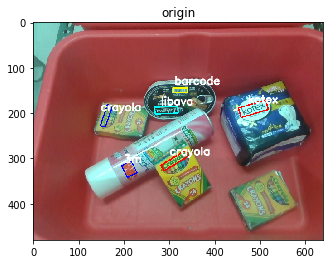